In [129]:
import re
import itertools
from collections import Counter
import dateutil.parser
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [130]:
# local modules
import sys
sys.path.append('../analysis')
from readers import read_ldjson
from text import standard_stopwords, tokenize, nlp, parse
from speeches import Speech

In [131]:
# mending plots
from adjustText import adjust_text

In [132]:
# from wordcloud import WordCloud

## Load speech groups

In [133]:
all_datapaths = [
    'tapp/inaugurals.json', 
    'millercenter/speeches.json',
    'tapp/election2016.json', 
    'tapp/election2012.json',
    'tapp/election2008.json',
    'tapp/transition2017.json',
    'trump.json',
    'michael-anton.json',
]

In [134]:
def iter_speeches(datapaths):
    for datapath in datapaths:
        for speech_dict in read_ldjson('../data/' + datapath):
            speech = Speech(**speech_dict)
            speech.datapath = datapath
            # a lot of 2012 speeches are just a YouTube video; exclude those
            if len(speech.text) > 0:
                yield speech
all_speeches = list(iter_speeches(all_datapaths))

In [135]:
war_date = dateutil.parser.parse('1948-11-01')
is_prewar = lambda speech: speech.timestamp < war_date
is_postwar = lambda speech: speech.timestamp > war_date
is_trump = lambda speech: speech.author == 'Donald J. Trump'
isnt_trump = lambda speech: speech.author != 'Donald J. Trump'
is_obama = lambda speech: speech.author == 'Barack Obama'
is_tapp_inaugural = lambda speech: speech.datapath == 'tapp/inaugurals.json'
is_millercenter = lambda speech: speech.datapath == 'millercenter/speeches.json'
def is_campaign_speech(year):
    datapath = 'tapp/election{}.json'.format(year)
    return lambda speech: (speech.metadata.get('category') == 'campaign speeches' and 
                           speech.datapath == datapath)
is_transition2017 = lambda speech: speech.datapath == 'millercenter/speeches.json'
is_inoffice = lambda speech: not speech.datapath.startswith('tapp/election')

In [136]:
groupspecs = [
    ('inaugurals',                  'All inaugural addresses',
      is_tapp_inaugural),
    ('inaugurals_prewar',           'Pre-war inaugural addresses',
      is_tapp_inaugural, is_prewar),
    ('inaugurals_postwar_pretrump', 'Post-war, pre-Trump inaugural addresses',
      is_tapp_inaugural, is_postwar, isnt_trump),
    ('inaugurals_pretrump',         'All prior inaugural addresses',
      is_tapp_inaugural, isnt_trump),
    ('inaugurals_trump',            'Trump inaugural address',
      is_tapp_inaugural, is_trump),
    ('millercenter',                'All Miller Center speeches',
      is_millercenter),
    ('election2008_speeches',       'All 2008 campaign speeches',
      is_campaign_speech(2008)),
    ('election2012_speeches',       'All 2012 campaign speeches',
      is_campaign_speech(2012)),
    ('election2016_speeches',       'All 2016 campaign speeches',
      is_campaign_speech(2016)),
    ('election2016_speeches_trump', 'Trump campaign speeches',
      is_campaign_speech(2016), is_trump),
    ('transition2017_trump',        'Transition 2017: Trump',
      is_transition2017, is_trump),
    ('transition2017_obama',        'Transition 2017: Obama',
      is_transition2017, isnt_trump),
    ('president_trump',             'President Trump, in office',
      is_inoffice, is_trump),
]

In [137]:
class Group(object):
    def __init__(self, name, fullname, *predicates):
        self.name = name
        self.fullname = fullname
        self.speeches = [speech for speech in all_speeches 
                         if all(predicate(speech) for predicate in predicates)]
    
    def __len__(self):
        return len(self.speeches)
    
    def __repr__(self):
        return '<Group {} "{}" ({} speeches)>'.format(self.name, self.fullname, len(self))

    @property
    def description(self):
        return '{} ({})'.format(self.fullname, len(self))

In [104]:
groups = [Group(*groupspec) for groupspec in groupspecs]

In [105]:
groups_lookup = {group.name: group for group in groups}

In [106]:
def iter_groupinfos(groups):
    for group in groups:
        yield group.name, group.fullname, len(group)
pd.DataFrame(iter_groupinfos(groups), columns=['group_name', 'group_fullname', 'documents'])

,group_name,group_fullname,documents
0,inaugurals,All inaugural addresses,58
1,inaugurals_prewar,Pre-war inaugural addresses,40
2,inaugurals_postwar_pretrump,"Post-war, pre-Trump inaugural addresses",17
3,inaugurals_pretrump,All prior inaugural addresses,57
4,inaugurals_trump,Trump inaugural address,1
5,millercenter,All Miller Center speeches,962
6,election2008_speeches,All 2008 campaign speeches,686
7,election2012_speeches,All 2012 campaign speeches,281
8,election2016_speeches,All 2016 campaign speeches,383
9,election2016_speeches_trump,Trump campaign speeches,60


# Proportion of speech allocated to specific word groups

In [107]:
def create_group_synset_df(groups, synsets):
    '''
    groups are a list of (group_name, Group instance) pairs
    synsets is a list of (synset_name, synset_tokens) pairs
    '''
    def iter_group_synset_counts(groups, synsets):
        for group_name, group in groups:
            #collocation_mapping = dict(nlp.sentence_collocation_mapping(speech.document for speech in group.speeches))
            for speech in group.speeches:
                speech_counts = speech.lower_counts
                total_count = len(speech_counts.values())
                for synset_name, synset_tokens in synsets:
                    #synset_tokens = nlp.bootstrap_strings(synset_tokens, collocation_mapping, 10)
                    #synset_lemmas = {token.lemma for token in nlp.parse(' '.join(synset_tokens))}
                    #synset_count = sum(speech.lemma_counts.get(lemma, 0) for lemma in synset_lemmas)
                    synset_orths = {token.lower for token in parse(' '.join(synset_tokens))}
                    synset_count = sum(speech_counts.get(orth, 0) for orth in synset_orths)
                    yield dict(group=group_name, synset=synset_name,
                               synset_count=synset_count, total_count=total_count)
    df = pd.DataFrame(iter_group_synset_counts(groups, synsets))
    # there's probably an easier way to do this in one go with df.pivot_table(...)
    df_grouped = df.groupby(['synset', 'group']).aggregate({'synset_count': sum, 'total_count': sum})
    df_grouped['synset_proportion'] = df_grouped.synset_count / df_grouped.total_count
    return df_grouped.reset_index(1)

def create_group_x_synset_df(groups, synsets):
    df = create_group_synset_df(groups, synsets)
    df_pivot = df.pivot(columns='group', values='synset_proportion')
    # reorder columns and rows to match order in groups and synsets lists
    return df_pivot[[name for name, _ in groups]].reindex([name for name, _ in synsets])

In [108]:
base_synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('libert(y/ies)', ['liberty', 'liberties']),
    ('rights', ['rights']), 
    ('public', ['public']), 
    #('right(s)', ['right', 'rights']),
    ('justice', ['justice']),
    ('peace(ful)', ['peace', 'peaceful']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
    ('constitution', ['constitution']),
    ('russia/ussr', ['russia', 'ussr']),
    ('china', ['china']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
    #('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('great(er/est)', ['great', 'greater', 'greatest']),
    #('trump', ['trump']),
    #('donald', ['donald']),
    ('freedom+liberty+rights+public', ['freedom', 'liberty', 'rights', 'public']),
]
base_synsets_lookup = dict(base_synsets)
def combine_synsets(*keys):
    return '+'.join(keys), [token for key in keys for token in base_synsets_lookup[key]]
synsets = base_synsets + [
    combine_synsets('freedom(s)', 'libert(y/ies)'),
    combine_synsets('freedom(s)', 'libert(y/ies)', 'rights', 'public'),
    ('china-et-al', ["china", "mexico", "military", "hell", 
                     "iran", "tough", "disaster" "horrible", 
                     "worst", "strong", "isis", "immigration", "border", "borders"]),
    #combine_synsets(['trump', 'donald']),
]
synsets_lookup = dict(synsets)

In [109]:
focus_group_names = [
    'millercenter', 
    'inaugurals_pretrump',
    'election2008_speeches',
    'election2012_speeches',
    'election2016_speeches',
    'election2016_speeches_trump',
    'inaugurals_trump', 
#     'transition2017_trump',
#     'transition2017_obama',
#     'president_trump',
]
focus_groups = [(group_name, groups_lookup[group_name]) for group_name in focus_group_names]
    
#'america(n(s))', 'job(s)',
focus_synset_names = [
    'freedom(s)', 
#     'peace(ful)', 
#     'justice', 
    'libert(y/ies)', 
    'rights', 
    'public',
#     'freedom(s)+libert(y/ies)+rights+public',
#     'freedom+liberty+rights+public',
]
focus_synsets = [(synset_name, synsets_lookup[synset_name]) for synset_name in focus_synset_names]

In [127]:
# df = create_group_synset_df(focus_groups, focus_synsets)
# df.reset_index().set_index(['synset', 'group']).synset_proportion
# df_flat = df.reset_index()
# df_pivot = df_flat.pivot_table('synset_proportion', 'synset', 'group')
# df_pivot.reindex(focus_synset_names)[focus_group_names]

In [113]:
# (df[df.group == 'election2016_speeches_trump'].synset_proportion /
#  df[df.group == 'inaugurals_pretrump'].synset_proportion).to_frame('trump/inaugurals')

In [122]:
df = create_group_x_synset_df(focus_groups, focus_synsets)
df

group,millercenter,inaugurals_pretrump,election2008_speeches,election2012_speeches,election2016_speeches,election2016_speeches_trump,inaugurals_trump
synset,,,,,,,
freedom(s),0.002445,0.004309,0.001200,0.002541,0.001028,0.000434,0.001835
libert(y/ies),0.001147,0.003045,0.000380,0.001440,0.000452,0.000269,0.000000
rights,0.002484,0.003113,0.001329,0.000938,0.001684,0.000496,0.000000
public,0.005433,0.005121,0.001570,0.000711,0.001779,0.001944,0.001835


In [123]:
1/df

group,millercenter,inaugurals_pretrump,election2008_speeches,election2012_speeches,election2016_speeches,election2016_speeches_trump,inaugurals_trump
synset,,,,,,,
freedom(s),409.035857,232.083770,833.530179,393.526508,972.637771,2302.285714,545.000000
libert(y/ies),871.709434,328.355556,2633.783505,694.383871,2212.408451,3719.076923,inf
rights,402.619608,321.217391,752.509573,1065.638614,593.879017,2014.500000,inf
public,184.066135,195.277533,637.099751,1406.921569,562.007156,514.340426,545.000000


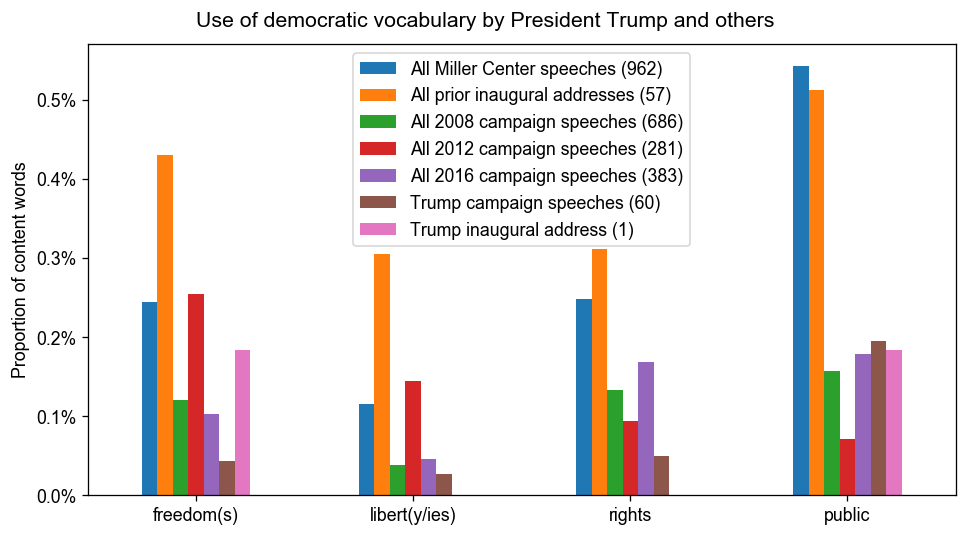

In [126]:
group_descriptions = {group.name: group.description for group in groups}
ax = df.rename(columns=group_descriptions).plot(figsize=(8.5, 4.5), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y)))
legend = ax.legend()
legend.set_title(None)
# plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.legend(loc='best')
plt.xticks(rotation=0)
plt.ylabel('Proportion of content words')
plt.suptitle('Use of democratic vocabulary by President Trump and others', y=1.02)
# plt.title('(bootstrapping seed terms with top 10 collocations in each group)')
plt.tight_layout()
# plt.savefig('democratic_vocabulary_proportions-bootstrapped.pdf')

In [363]:
def iter_synsets_bootstrapped(speeches, synsets, n):
    collocation_mapping = dict(nlp.sentence_collocation_mapping(speech.document for speech in speeches))
    for synset_name, synset_tokens in synsets:
        for bootstrapped_token in nlp.bootstrap_strings(synset_tokens, collocation_mapping, n):
            yield synset_name + ' = ' + ', '.join(synset_tokens), bootstrapped_token

In [364]:
df_bootstrapped = pd.DataFrame(iter_synsets_bootstrapped(inaugurals.speeches, focus_synsets, 10),
                               columns=['synset', 'bootstrapped_token'])

In [366]:
# df_bootstrapped.set_index(['synset', 'bootstrapped_token'])

In [259]:
# df_bootstrapped.pivot(columns='synset', values='bootstrapped_token')

# Trump over time

In [704]:
# pd.options.display.max_rows = 20

In [113]:
def create_timeseries_df(df, values='synset_proportion_smoothed', columns='synset', ax=None):
    df_pivot = df.reset_index().pivot_table(values=values, index='timestamp', columns=columns)
    ax = df_pivot.plot(kind='line', ax=ax, grid=True)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.02%}'.format(y)))
    ax.legend(loc='best').set_title(None)
    #ax.set_xlabel('Speech date')
    ax.set_ylabel('Percentage of content words')
    return df_pivot

In [114]:
focus_synset_names = {
    'freedom(s)', 'libert(y/ies)', 'rights', 'public',
    #'america(n(s))', 'job(s)',
}
focus_synsets = [(synset_name, synset_tokens) for synset_name, synset_tokens in synsets
                 if synset_name in focus_synset_names]

In [115]:
df = pd.DataFrame(iter_speeches_counts(speeches['trump_election2016_speeches'], focus_synsets, standard_stopwords)).\
    sort_values('timestamp').set_index(['synset', 'id'], verify_integrity=True)
df['synset_proportion_smoothed'] = df.groupby(level='synset', group_keys=False).apply(
    lambda g: g.synset_proportion.rolling(10, min_periods=1, center=True).mean()
)

KeyError: 'trump_election2016_speeches'

In [711]:
daily_speeches = df.reset_index().drop_duplicates(['id']).groupby('timestamp').size()
# daily_speeches

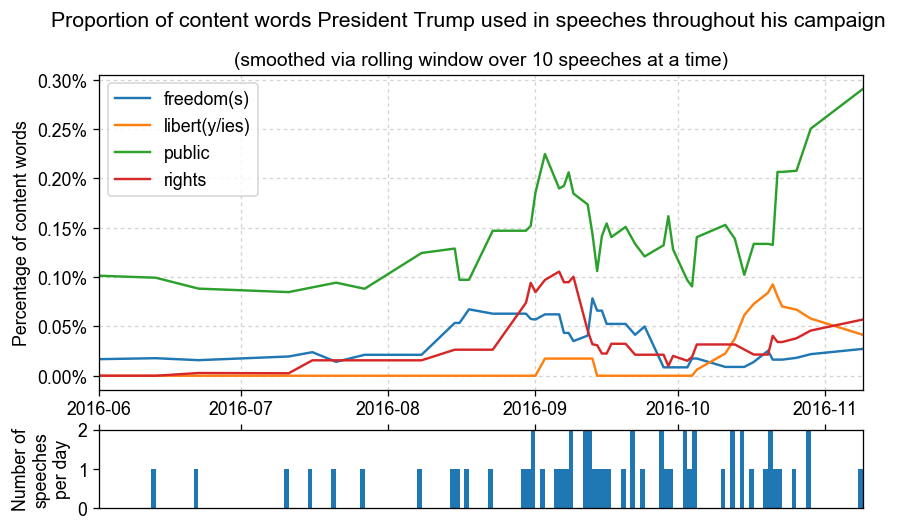

In [712]:
fig = plt.figure()#figsize=(12,5))
grid = mgridspec.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])

# produce top synsets plot
synset_ax = fig.add_subplot(grid[0])
synset_ax.tick_params(labelbottom='off')
synset_ax.xaxis.label.set_visible(False)
plot_timeseries(df, ax=synset_ax)
synset_ax.set_title('(smoothed via rolling window over %d speeches at a time)' % smoothing_window, {'fontsize': 12})

# produce bottom daily speeches plot
daily_ax = fig.add_subplot(grid[1])
daily_ax.xaxis.tick_top()
# for a bar plot, width=-1, align='edge' is like width=1, align='right' except 'right' isn't a valid align value
daily_ax.bar(timestamp_counts.index, timestamp_counts.values, width=-1, align='edge') # width is in days?
daily_ax.set_ylabel('Number of\nspeeches\nper day')

# trim axes the same
min_x = pd.to_datetime('2016-06-01')
max_x = pd.to_datetime('2016-11-09')
synset_ax.set_xlim(min_x, max_x)
daily_ax.set_xlim(min_x, max_x)
daily_ax.set_ylim(None, 2)

plt.suptitle('Proportion of content words President Trump used in speeches throughout his campaign')
# fig.tight_layout()

# Significant others

In [40]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [41]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [43]:
groups = [
    ('inaugural', speeches_counts['inaugurals_pretrump']),
    ('trump', speeches_counts['trump_inaugurals']),
]
for group_name, group_counts in groups:
    print '|{:}_counts| = {:d}'.format(group_name, sum(group_counts.values()))

|inaugural_counts| = 58029
|trump_counts| = 622


In [44]:
full_vocab = set([token for _, counts in groups for token in counts.keys()])
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 8975


In [45]:
k = 500
smoothing = 1.0

In [48]:
df_counts = pd.DataFrame.from_dict(iter_group_counts(groups, full_vocab, smoothing)).\
    groupby('group').apply(set_proportion)
# df_counts[df_counts.proportion > 0.0005]
# df_counts

In [49]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': np.mean})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [50]:
vocab = set(df_proportions_merged.nlargest(k, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 500


In [51]:
# print ' '.join(vocab)

In [999]:
# could take a second depending on how rare the vocab is
# vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [54]:
# recount with condensed vocab
# df_counts = pd.DataFrame.from_dict(iter_group_counts(groups, vocab, smoothing)).\
#     groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

In [55]:
# trump_counts = df_counts[df_counts.group=='trump']
# trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# trump_counts_reordered = trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# trump_counts_reordered[trump_counts_reordered.word=='donald']

In [56]:
# inaugural_counts = df_counts[df_counts.group=='inaugural']
# inaugural_counts = inaugural_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# pd.options.display.max_rows = 100
# inaugural_counts

### Oh boy word clouds

In [59]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

In [61]:
# for group, group_df in df_counts.groupby('group'):
#     plt.figure(figsize=(8.5, 4))
#     display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
#     plt.title(group)

### Back to business

That's nice to look at, but we also want some consistent ordering of relative inaugural-ness vs. Trumpery.

We can get that just by dividing one over the other. We'll use Trump proportion / Inaugural proportion, so higher values will indicate higher Trumpery.

In [62]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural

The ratio produces the desired ordering, but it ranges from very tiny values,
to 1 (meaning similar usage), to arbitrarily large values.

As we'll seen in a second with the (log-log) scatter plot, what we want is a sort of radial / angular measure.
The words around the y=x diagonal see similar usage, with the words in the upper-left being more Trump-ish and the words in the lower-right being more Inaugural.
Yay trigonometry!

In [63]:
#rad = np.arctan(df_proportions['trump/inaugural'])
rad = np.arctan2(df_proportions.trump, df_proportions.inaugural)
# re-map from [0, pi/2] to [-1, 1]
df_proportions[u'trump°inaugural'] = rad * (4.0 / np.pi) + -1.0

In [64]:
df_proportions = df_proportions.sort_values(u'trump°inaugural')

In [65]:
# df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies.get(k, 1))

In [67]:
# plt.figure(figsize=(8.5, 8.5))
# x = df_proportions['inaugural']
# plt.xscale('log')
# # plt.xlabel('global frequency of word (based on Google 1T unigrams)')
# plt.xlabel('inaugural-ness')
# y = df_proportions['trump']
# plt.yscale('log')
# # plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
# plt.ylabel('trumpery')
# # points
# plt.scatter(x, y, c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50)
# annotations = []
# for label, x, y in zip(df_proportions.index, x, y):
#     annotation = plt.annotate(label, xy=(x, y), xytext=(2, 2),
#                  size='large',
#                  textcoords='offset points', ha='left', va='bottom')
#     annotations.append(annotation)
# adjust_text(annotations, force_text=0.08, arrowprops=dict(arrowstyle="-|>", color='k', alpha=0.33))    
# plt.tight_layout()

That's neat, but kind of a mess. More directly, we can look at the actual ranking.

In [69]:
pd.options.display.max_rows = 10
df_proportions

group,inaugural,trump,trump/inaugural,trump°inaugural
word,,,,
peace,0.009134,0.001181,0.129257,-0.836333
constitution,0.007493,0.001181,0.157570,-0.801012
freedom,0.006815,0.001181,0.173245,-0.781586
union,0.006743,0.001181,0.175078,-0.779320
war,0.006387,0.001181,0.184859,-0.767258
...,...,...,...,...
dreams,0.000535,0.007084,13.235891,0.903986
factories,0.000250,0.004723,18.908416,0.932725
borders,0.000250,0.004723,18.908416,0.932725


Still, it's a lot of numbers. Let's discretize.

### Categories of trumpiness 

Having an ordering on the words means we can bin the words in discrete chunks.

The `trump/inaugural` ratio is monotonic with the `trump°inaugural` column, but since the latter has a nicer scale, we'll use it.

In [70]:
# equal bin widths:
# _, binedges = np.histogram(df_proportions[u'trump°inaugural'], bins=7)
# equal bin depths:
binedges = np.percentile(df_proportions[u'trump°inaugural'], np.linspace(0, 100, 8))

In [71]:
binnames = ['Most presidential', '2nd-most presidential', '3rd-most presidential',
            'Neutral', 
            '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy']
assignments = np.digitize(df_proportions[u'trump°inaugural'], binedges[:-1]) - 1
df_proportions['trumpiness'] = np.array(binnames)[assignments]

In [72]:
trumpiness_bins = [(name, pd.Series(list(group_df.sort_values(u'trump°inaugural', ascending=True).word)))
                   for name, group_df in df_proportions.reset_index().groupby('trumpiness')]
df_bins = pd.DataFrame(dict(trumpiness_bins)).fillna('')
df_bins = df_bins[binnames]

In [73]:
pd.options.display.max_rows = 40
# df_bins

# Focus

How about we focus in on a couple specific words.

In [76]:
# pd.options.display.max_rows = 200
# df_proportions.sort_values(u'trump°inaugural')

In [77]:
df_proportions_sorted = df_proportions.sort_values(u'trump°inaugural')

In [78]:
extremes_k = 20
pd.options.display.max_rows = extremes_k * 2
df_proportions_sorted

group,inaugural,trump,trump/inaugural,trump°inaugural,trumpiness
word,,,,,
peace,0.009134,0.001181,0.129257,-0.836333,Most presidential
constitution,0.007493,0.001181,0.157570,-0.801012,Most presidential
freedom,0.006815,0.001181,0.173245,-0.781586,Most presidential
union,0.006743,0.001181,0.175078,-0.779320,Most presidential
war,0.006387,0.001181,0.184859,-0.767258,Most presidential
government,0.021515,0.004723,0.219501,-0.724886,Most presidential
rights,0.004960,0.001181,0.238056,-0.702437,Most presidential
laws,0.004745,0.001181,0.248795,-0.689528,Most presidential
congress,0.004674,0.001181,0.252593,-0.684978,Most presidential


In [367]:
ranked_words = list(df_proportions.sort_values(u'trump°inaugural').index)
extremes = {
    'inaugural': ranked_words[:extremes_k],
    'trump': ranked_words[-extremes_k:],
}
extremes_vocab = set(reduce(operator.add, extremes.values()))
keywords_vocab = {'freedom', 'freedoms', 'liberty', 'liberties', 'rights', 'justice',
                  'borders', 'protected', 'jobs', 'families', 'factories', 'wealth'}

NameError: name 'df_proportions' is not defined

In [90]:
# df_proportions_subset = df_proportions[df_proportions.index.isin(extreme_40)]
df_proportions_subset = df_proportions

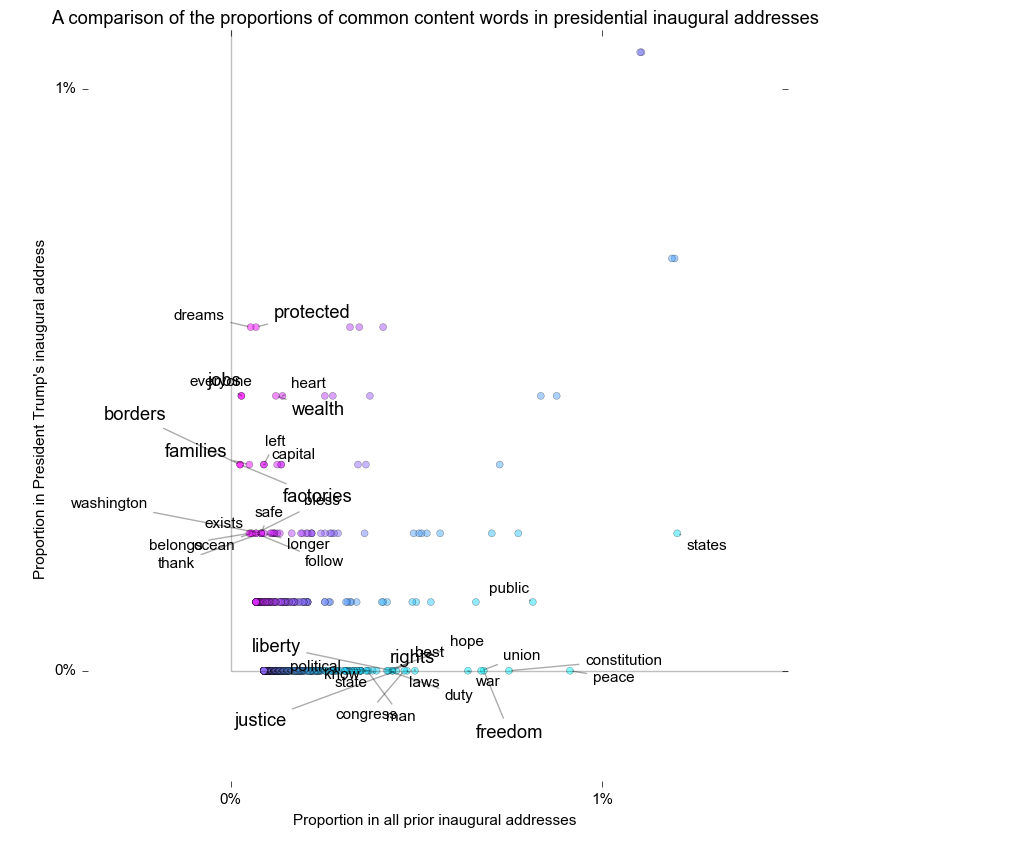

In [177]:
plt.figure(figsize=(8.5, 8.5))
xs = df_proportions_subset.inaugural
plt.xlabel("Proportion in all prior inaugural addresses")
ys = df_proportions_subset.trump - min(df_proportions_subset.trump)
plt.ylabel("Proportion in President Trump's inaugural address")
# points
plt.scatter(xs, ys, 
            c=df_proportions_subset[u'trump°inaugural'], cmap=plt.cm.cool, #c='#27BC8A',
            linewidths=.3, s=25, alpha=0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
# labels
annotations = []
for index, (label, x, y) in enumerate(zip(df_proportions_subset.index, xs, ys)):
    if label in extremes_vocab:
        size = 'large' if label in keywords_vocab else None
        annotation = plt.text(x, y, label, size=size)
        #annotation = plt.annotate(label, xy=(x, y), size=size)
        #, xytext=(2, 2), textcoords='offset points', ha='left', va='bottom')
        annotations.append(annotation)
# adjustments
adjust_text(annotations, force_text=0.012, force_points=0.4,
            arrowprops=dict(arrowstyle="-", color='k', alpha=0.33), lim=1000)
# plt.xlim(-2.0*margin, 0.015)
# plt.ylim(-2.0*margin, 0.015)
#plt.plot([0, plt.xlim()[1]], [0, plt.ylim()[1]])
# plt.xlim(-2.0*margin, max(xs) + 0.0017)
# plt.ylim(-.5*margin, 0.0075)
plt.vlines(0, 0, 1, alpha=0.25)
plt.hlines(0, 0, 1, alpha=0.25)
plt.title('A comparison of the proportions of common content words in presidential inaugural addresses')
plt.xlim(-0.004, 0.015)
plt.ylim(-0.002, 0.011)
# add %-age ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(np.arange(0, plt.xlim()[1], 0.01))
plt.yticks(np.arange(0, plt.ylim()[1], 0.01))
plt.tight_layout()
# plt.savefig('inaugural_scatter_labeled_v2.pdf')